In [1]:
# some code implemented from youtube tutorial from Madhav Thaker
# https://github.com/madhavthaker/spotify-recommendation-system

In [2]:
import pandas as pd
import numpy as np
import json
from IPython.display import Image
from IPython.core.display import display, HTML
import itertools
import sys
import re
import os
import matplotlib.pyplot as plt
from skimage import io
from IPython.display import Image

# Spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

url = os.getcwd()

In [3]:
%matplotlib inline
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [4]:
from secrets import client_id, client_secret

scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

# Spotify access
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')
sp = spotipy.Spotify(auth=token)

In [5]:
def get_users_playlists():
    playlist_names = {}
    playlist_photos = {}
    
    for i in sp.current_user_playlists()['items']:
        playlist_names[i['name']] = i['uri'].split(':')[2]
        playlist_photos[i['uri'].split(':')[2]] = i['images'][0]['url']
    
    return playlist_names, playlist_photos

# Call get_users_playlists()
playlist_names, playlist_photos = get_users_playlists()
#playlist_names

In [6]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [7]:
def get_track_info(playlist_id,tracks, number):
    # Track
    track = tracks[number]
    added_by = track['added_by']['id']
    track_info = track['track']
    track_artist = track_info['artists'][0]
    track_album = track_info['album']

    # Informations about the track
    id = track_info['id']
    name = track_info['name']
    popularity = track_info['popularity']
    #print(f"{id} + {name}")
    if( 'spotify' in track_info):
        link = ""
    else:
        link = track_info['external_urls']['spotify']
    preview_url = track_info['preview_url']

    # Informations about the artists
    artist_id = track_artist['id']
    artist_name = track_artist['name']
    
    # get tracks album image
    image_url = track_album['images'][1]['url']

    
    track_out = {
        'playlist_id': playlist_id,
        'id': id,
        'name': name,
        'link': link,
        'popularity': popularity,
        'image_url': image_url,
        'preview_url': preview_url,
        'artist_id': artist_id,
        'artist_name': artist_name
    }
    return track_out


In [8]:
def track_info(id_playlist):
    track_info = []
    for playlist_name, playlist_id in playlist_names.items():
        if(str(playlist_id) == id_playlist):
            tracks = get_playlist_tracks("davitoz", playlist_id)
            for track_number in range(0, len(tracks)):
                track_info.append(get_track_info(playlist_id, tracks, track_number))
    return pd.DataFrame(track_info)
from_edits_ = track_info("5Yi5I6uqMn9oyV3RhvUVNm")

In [9]:
track_info_df

,playlist_id,id,name,link,popularity,image_url,preview_url,artist_id,artist_name
0,5Yi5I6uqMn9oyV3RhvUVNm,1iTJWaXWJE03Ek1qWGOfAo,This Night,https://open.spotify.com/track/1iTJWaXWJE03Ek1...,42,https://i.scdn.co/image/ab67616d00001e022a9191...,https://p.scdn.co/mp3-preview/2948d6637d563e18...,0xccdX954kn4RxZypGF7KH,Black Lab
1,5Yi5I6uqMn9oyV3RhvUVNm,5KGbRvZyVyKP2AEJMHErB4,Old Yellow Bricks,https://open.spotify.com/track/5KGbRvZyVyKP2AE...,68,https://i.scdn.co/image/ab67616d00001e02b1f8da...,https://p.scdn.co/mp3-preview/87d579931c809534...,7Ln80lUS6He07XvHI8qqHH,Arctic Monkeys
2,5Yi5I6uqMn9oyV3RhvUVNm,15BQ7vEDv2LJuh8TxWIhtd,The Passenger,https://open.spotify.com/track/15BQ7vEDv2LJuh8...,74,https://i.scdn.co/image/ab67616d00001e024aa5f6...,None,33EUXrFKGjpUSGacqEHhU4,Iggy Pop
3,5Yi5I6uqMn9oyV3RhvUVNm,1aJtyIMev4kW8IMUxOjn1Y,Glitter & Gold,https://open.spotify.com/track/1aJtyIMev4kW8IM...,56,https://i.scdn.co/image/ab67616d00001e02ef510a...,None,5tFRohaO5yEsuJxmMnlCO9,Barns Courtney
4,5Yi5I6uqMn9oyV3RhvUVNm,1Q70pQzaBGWrWU16xrYLGb,Mrs. Robinson,https://open.spotify.com/track/1Q70pQzaBGWrWU1...,37,https://i.scdn.co/image/ab67616d00001e02969998...,https://p.scdn.co/mp3-preview/f558ed04819a4992...,6w7fc6IZlo5zwBaKT5jU1X,The Lemonheads
5,5Yi5I6uqMn9oyV3RhvUVNm,17DjxJJG1NHXg1VatxfFfU,The Underdog,https://open.spotify.com/track/17DjxJJG1NHXg1V...,0,https://i.scdn.co/image/ab67616d00001e021aacf2...,None,0K1q0nXQ8is36PzOKAMbNe,Spoon
6,5Yi5I6uqMn9oyV3RhvUVNm,2IZZqH4K02UIYg5EohpNHF,Zombie,https://open.spotify.com/track/2IZZqH4K02UIYg5...,82,https://i.scdn.co/image/ab67616d00001e02e2213d...,None,7t0rwkOPGlDPEhaOcVtOt9,The Cranberries
7,5Yi5I6uqMn9oyV3RhvUVNm,3bINd6fURyFLT0sQwkjbCG,Over The Rainbow,https://open.spotify.com/track/3bINd6fURyFLT0s...,0,https://i.scdn.co/image/ab67616d00001e02b0e51b...,None,4ogvuDRerGhZfSf7TtzHlr,Israel Kamakawiwo'ole
8,5Yi5I6uqMn9oyV3RhvUVNm,7aXK1UkGw6bDc2zr4YUpdJ,Hard-Core Troubadour,https://open.spotify.com/track/7aXK1UkGw6bDc2z...,46,https://i.scdn.co/image/ab67616d00001e02a352d8...,https://p.scdn.co/mp3-preview/efd06c8de4eadfaf...,2UBTfUoLI07iRqGeUrwhZh,Steve Earle
9,5Yi5I6uqMn9oyV3RhvUVNm,5d1ix6uxnaiPzQpWjoOtrN,Bet on You,https://open.spotify.com/track/5d1ix6uxnaiPzQp...,48,https://i.scdn.co/image/ab67616d00001e026f1162...,https://p.scdn.co/mp3-preview/00a8fe897cbce6fb...,1wLFDPkWkMl7bNZvhmhxsG,The Man Who


In [10]:
#find if there exists duplicates
## TODO: 

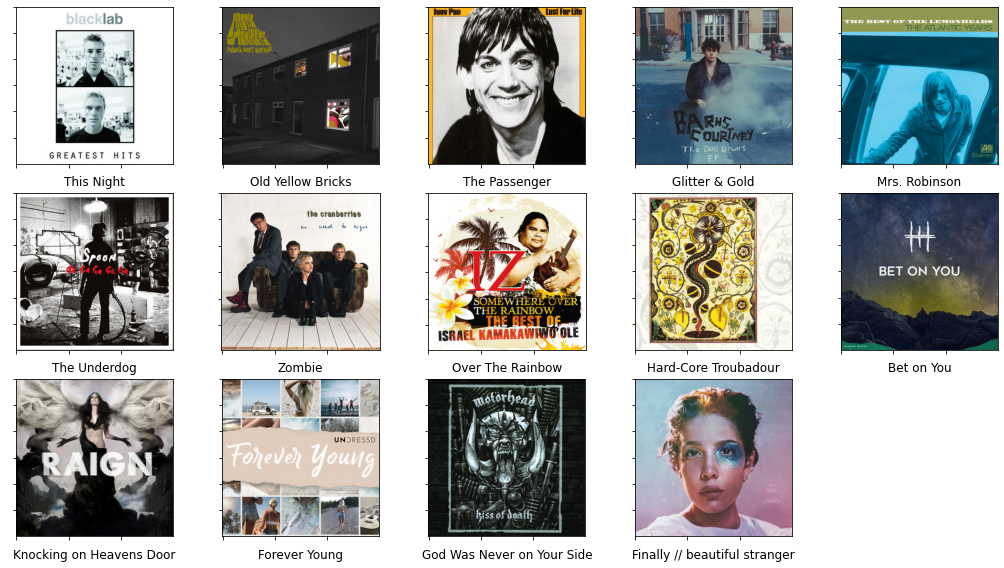

In [11]:
from skimage import io
import matplotlib.pyplot as plt

def cover_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    image_url = df['image_url'].values
    plt.figure(figsize=(15,int(0.625 * len(image_url))))
    columns = 5
    
    for i, url in enumerate(image_url):
        plt.subplot(len(image_url) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

cover_songs(track_info_df)

In [12]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [13]:
playlist_EDM = create_necessary_outputs('From edits', playlist_names,spotify_df)
playlist_chill = create_necessary_outputs('Eyeex',playlist_names, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

NameError: name 'spotify_df' is not defined

In [ ]:
## show all recommendations

In [ ]:
## show bad recommendations (low popularity)

In [ ]:
## show good recommendations (high popularity)